In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AV2_MAD/dataset_16.csv')

# Parte 1

In [49]:
print(f'''
======= Primeiras 5 linhas =======

{df.head()}

======= Tipos de dados e valores ausentes =======

{df.info()}
{df.isnull().sum()}

======= Estatisticas gerais =======

{df.describe()}
''')

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 0 to 186
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cpu_cores            138 non-null    int64  
 1   ram_gb               138 non-null    int64  
 2   latencia_ms          138 non-null    float64
 3   armazenamento_tb     138 non-null    float64
 4   sistema_operacional  138 non-null    object 
 5   tipo_hd              138 non-null    object 
 6   tipo_processador     138 non-null    object 
 7   tempo_resposta       138 non-null    float64
dtypes: float64(3), int64(2), object(3)
memory usage: 9.7+ KB

======= Primeiras 5 linhas =======

   cpu_cores  ram_gb  latencia_ms  armazenamento_tb sistema_operacional  \
0         14      16       212.37             0.512               Linux   
1          2      32        97.34             1.000               MacOS   
2          6      16       253.45             1.000               Linux   
3 

# Parte 2

                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     54.58
Date:                Tue, 06 May 2025   Prob (F-statistic):           8.99e-38
Time:                        22:44:01   Log-Likelihood:                -654.93
No. Observations:                 138   AIC:                             1328.
Df Residuals:                     129   BIC:                             1354.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

<ipython-input-35-af97d3cbbba2>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mediana, inplace=True)
<ipython-input-35-af97d3cbbba2>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.meth

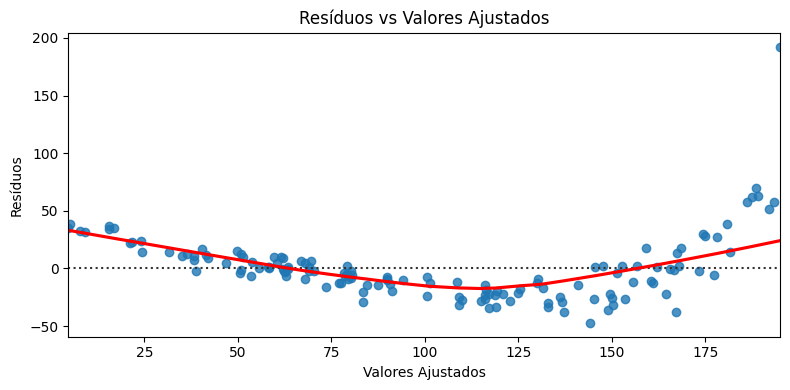

In [ ]:
# Identificando variáveis categóricas e numéricas
categoricas = ['sistema_operacional', 'tipo_hd', 'tipo_processador']
numericas = df.drop(columns=categoricas).select_dtypes(include='number').columns.tolist()

# Preencher valores nulos
for col in numericas:
    mediana = df[col].median()
    df[col].fillna(mediana, inplace=True)

for col in categoricas:
    moda = df[col].mode()[0]
    df[col].fillna(moda, inplace=True)

# Codificação dummy, removendo a primeira categoria base
df_dummies = pd.get_dummies(df, columns=categoricas, drop_first=True)

# Definindo a variável dependente e as explicativas
y = df_dummies['tempo_resposta']
x = df_dummies.drop(columns='tempo_resposta')

# Constante do modelo
x = sm.add_constant(x)
x = x.astype(float)

# Ajustando o modelo de regressão
model = sm.OLS(y, x).fit()

print(model.summary())

# Calculando o VIF para analisar a multicolinearidade
vif_data = pd.DataFrame()
vif_data['variavel'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

print("\nFatores de Inflação da Variância (VIF)")
print(vif_data)

# Teste de Breusch-Pagan para analisar a heterocedasticidade
residuals = model.resid
exog = model.model.exog
bp_test = het_breuschpagan(residuals, exog)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
bp_results = dict(zip(labels, bp_test))

print("\nTeste de Breusch-Pagan")
for k, v in bp_results.items():
    print(f'{k}: {v:.4f}')

# Plotando resíduos vs valores ajustados
plt.figure(figsize=(8, 4))
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Ajustados')
plt.tight_layout()
plt.show()

# Parte 3


Modelo Alternativo sem latencia_ms:

                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     62.78
Date:                Wed, 07 May 2025   Prob (F-statistic):           1.16e-38
Time:                        00:50:42   Log-Likelihood:                -655.00
No. Observations:                 138   AIC:                             1326.
Df Residuals:                     130   BIC:                             1349.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

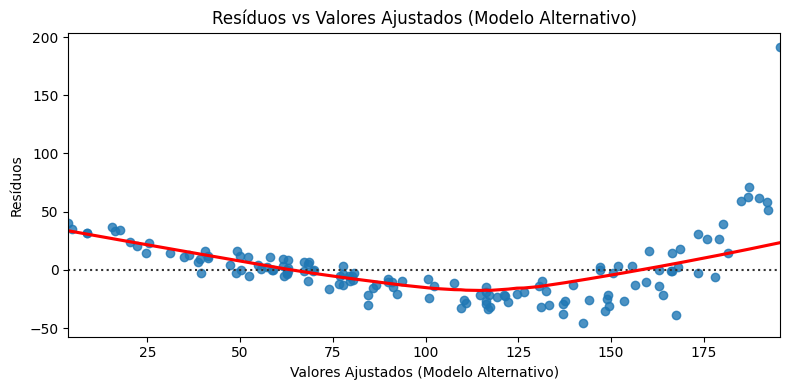

In [48]:
#Criando Modelo Alternativo
x_alt = x.drop(columns=['latencia_ms'])

modelo_alternativo = sm.OLS(y, x_alt).fit()

print("\nModelo Alternativo sem latencia_ms:\n")
print(modelo_alternativo.summary())

# 2. Comparando R² ajustado e Teste F entre os modelos

r2_original = model.rsquared_adj
r2_alternativo = modelo_alternativo.rsquared_adj
f_original = model.fvalue
f_alternativo = modelo_alternativo.fvalue

print("\nComparação entre Modelos:\n")
print(f"R² Ajustado - Modelo Original     : {r2_original:.4f}")
print(f"R² Ajustado - Modelo Alternativo  : {r2_alternativo:.4f}")
print(f"F-Estatística - Modelo Original   : {f_original:.2f}")
print(f"F-Estatística - Modelo Alternativo: {f_alternativo:.2f}")

# 3. Gráfico de resíduos do modelo alternativo
plt.figure(figsize=(8, 4))
sns.residplot(x=modelo_alternativo.fittedvalues, y=modelo_alternativo.resid, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Valores Ajustados (Modelo Alternativo)')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Ajustados (Modelo Alternativo)')
plt.tight_layout()
plt.show()
